In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from paddle.io import Dataset, DataLoader  
from PIL import Image
import paddle
import paddle as P
import paddle.nn as nn
import paddle.nn.functional as F
from paddle import ParamAttr
from paddle.nn import Conv2D, BatchNorm, Linear, Dropout, AdaptiveAvgPool2D, MaxPool2D, AvgPool2D
import pdb

nn.initializer.set_global_initializer(nn.initializer.Normal(mean=0.0,std=0.01), nn.initializer.Constant())

/home/chen/anaconda3/envs/paddle/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [2]:
def read_test_dataset(n):
    hr_dir = 'test/HR/'  
    lr_dir = 'test/inter_LR/'  
    lr0_dir = 'test/LR/'
    images=os.listdir(hr_dir)
    
    HR0=np.zeros((n,1,120,120)).astype("float32")
    LR0=np.zeros((n,1,120,120)).astype("float32")
    LR00=np.zeros((n,1,25,25)).astype("float32")
    
    for i in range(0,n):
        img_name=random.choice(images)  
        hr_img_path = os.path.join(hr_dir, img_name)  
        lr_img_path = os.path.join(lr_dir, img_name)  
        lr0_img_path = os.path.join(lr0_dir, img_name)  
    
        hr_img = Image.open(hr_img_path)
        hr_img=np.array(hr_img, dtype=np.float32)/255
        hr_img=hr_img[:,:,np.newaxis].transpose([2,0,1])
        HR0[i,:,:,:]=hr_img
    
        lr_img = Image.open(lr_img_path)
        lr_img=np.array(lr_img, dtype=np.float32)/255
        lr_img=lr_img[:,:,np.newaxis].transpose([2,0,1])
        LR0[i,:,:,:]=lr_img
    
        lr0_img = Image.open(lr0_img_path)
        lr0_img=np.array(lr0_img, dtype=np.float32)/255
        lr0_img=lr0_img[:,:,np.newaxis].transpose([2,0,1])
        LR00[i,:,:,:]=lr0_img
    HR=paddle.to_tensor(HR0)
    LR=paddle.to_tensor(LR0)
    LR_0=paddle.to_tensor(LR00)
    HR=HR*2-1
    LR=LR*2-1
    LR_0=LR_0*2-1
    return HR,LR,LR_0


In [3]:
# swin-transformer block
import math

import paddle
import paddle.nn as nn
import paddle.nn.functional as F


def to_2tuple(x):
    if isinstance(x, int):
        return (x, x)
    else:
        return tuple(x)


class Mlp(nn.Layer):

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.reshape((B, H // window_size, window_size, W // window_size, window_size, C))
    windows = x.transpose((0, 1, 3, 2, 4, 5)).reshape((-1, window_size, window_size, C))
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.reshape((B, H // window_size, W // window_size, window_size, window_size, -1))
    x = x.transpose((0, 1, 3, 2, 4, 5)).reshape((B, H, W, -1))
    return x


class WindowAttention(nn.Layer):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = self.create_parameter(shape=((2 * window_size[0] - 1) *
                                                                         (2 * window_size[1] - 1), num_heads),
                                                                  default_initializer=nn.initializer.Constant(0.0))

        # get pair-wise relative position index for each token inside the window
        coords_h = paddle.arange(self.window_size[0])
        coords_w = paddle.arange(self.window_size[1])
        coords = paddle.stack(paddle.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = paddle.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.transpose((1, 2, 0))  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias_attr=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        self.softmax = nn.Softmax(axis=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape((B_, N, 3, self.num_heads, C // self.num_heads)).transpose((2, 0, 3, 1, 4))
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose((0, 1, 3, 2)))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.reshape(
            (-1, ))].reshape((self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1],
                              -1))  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.transpose((2, 0, 1))  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.reshape((B_ // nW, nW, self.num_heads, N, N)) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.reshape((-1, self.num_heads, N, N))
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose((0, 2, 1, 3)).reshape((B_, N, C))
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Layer):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Layer, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Layer, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self,
                 dim,
                 input_resolution,
                 num_heads,
                 window_size=7,
                 shift_size=0,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(dim,
                                    window_size=to_2tuple(self.window_size),
                                    num_heads=num_heads,
                                    qkv_bias=qkv_bias,
                                    qk_scale=qk_scale,
                                    attn_drop=attn_drop,
                                    proj_drop=drop)

        self.drop_path = nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = paddle.zeros((1, H, W, 1))  # 1 H W 1

        h_slices = (slice(0, -self.window_size), slice(-self.window_size,
                                                       -self.shift_size if self.shift_size else None),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size), slice(-self.window_size,
                                                       -self.shift_size if self.shift_size else None),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.reshape((-1, self.window_size * self.window_size))

        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        _h = paddle.full_like(attn_mask, -100.0, dtype='float32')
        _z = paddle.full_like(attn_mask, 0.0, dtype='float32')
        attn_mask = paddle.where(attn_mask != 0, _h, _z)

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.reshape((B, H, W, C))

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = paddle.roll(x, shifts=(-self.shift_size, -self.shift_size), axis=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.reshape((-1, self.window_size * self.window_size, C))  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size))

        # merge windows
        attn_windows = attn_windows.reshape((-1, self.window_size, self.window_size, C))
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = paddle.roll(shifted_x, shifts=(self.shift_size, self.shift_size), axis=(1, 2))
        else:
            x = shifted_x
        x = x.reshape((B, H * W, C))

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Layer):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Layer, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.reshape((B, H, W, C))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = paddle.concat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.reshape((B, -1, 4 * C))  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Layer):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Layer, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Layer | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self,
                 dim,
                 input_resolution,
                 depth,
                 num_heads,
                 window_size,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 norm_layer=nn.LayerNorm,
                 downsample=None,
                 use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.LayerList([
            SwinTransformerBlock(dim=dim,
                                 input_resolution=input_resolution,
                                 num_heads=num_heads,
                                 window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias,
                                 qk_scale=qk_scale,
                                 drop=drop,
                                 attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer) for i in range(depth)
        ])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Layer):
    """Residual Swin Transformer Block (RSTB).
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Layer, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Layer | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self,
                 dim,
                 input_resolution,
                 depth,
                 num_heads,
                 window_size,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 norm_layer=nn.LayerNorm,
                 downsample=None,
                 use_checkpoint=False,
                 img_size=224,
                 patch_size=4,
                 resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias,
                                         qk_scale=qk_scale,
                                         drop=drop,
                                         attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2D(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2D(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2),
                                      nn.Conv2D(dim // 4, dim // 4, 1, 1, 0), nn.LeakyReLU(negative_slope=0.2),
                                      nn.Conv2D(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(img_size=img_size,
                                      patch_size=patch_size,
                                      in_chans=0,
                                      embed_dim=dim,
                                      norm_layer=None)

        self.patch_unembed = PatchUnEmbed(img_size=img_size,
                                          patch_size=patch_size,
                                          in_chans=0,
                                          embed_dim=dim,
                                          norm_layer=None)
        self.emb_layer = nn.Sequential(
            nn.Silu(),
            nn.Linear(
                256,
                dim
            ),
        )

    def forward(self, x, x_size):
        x_temp=self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))
        # return self.patch_embed(x_temp) + x
        return x_temp 
    
    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Layer):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Layer, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose((0, 2, 1))  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Layer):
    r""" Image to Patch Unembedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Layer, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose((0, 2, 1)).reshape((B, self.embed_dim, x_size[0], x_size[1]))  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2D(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2D(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. '
                             'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2D(num_feat, (scale**2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class Swin_Block(nn.Layer):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Layer): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self,
                 img_size=119,
                 patch_size=1,
                 in_chans=1,
                 embed_dim=96,
                 depths=[6, 6, 6, 6],
                 num_heads=[8, 8, 8],
                 window_size=5,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm,
                 ape=False,
                 patch_norm=True,
                 use_checkpoint=False,
                 upscale=2,
                 img_range=1.,
                 upsampler='pixelshuffle',
                 resi_connection='1conv',
                 **kwargs):
        super(Swin_Block, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = paddle.to_tensor(rgb_mean).reshape((1, 3, 1, 1))
        else:
            self.mean = paddle.zeros((1, 1, 1, 1))
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size
        self.time_dim = 256
        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2D(2, 64, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(img_size=img_size,
                                      patch_size=patch_size,
                                      in_chans=embed_dim,
                                      embed_dim=embed_dim,
                                      norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(img_size=img_size,
                                          patch_size=patch_size,
                                          in_chans=embed_dim,
                                          embed_dim=embed_dim,
                                          norm_layer=norm_layer if self.patch_norm else None)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in paddle.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule


        self.rstb = RSTB(
                dim=embed_dim,
                input_resolution=(patches_resolution[0], patches_resolution[1]),
                depth=depths[1],
                num_heads=num_heads[1],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:1]):sum(depths[:1 + 1])],  # no impact on SR results
                norm_layer=norm_layer,
                downsample=None,
                use_checkpoint=use_checkpoint,
                img_size=img_size,
                patch_size=patch_size,
                resi_connection=resi_connection)
        
        self.norm = norm_layer(self.num_features)
        

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.initializer.Constant(0.0)(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.initializer.Constant(0.0)(m.bias)
            nn.initializer.Constant(1.0)(m.weight)

    def check_image_size(self, x):
        _, _, h, w = x.shape
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (paddle.arange(0, channels, 2).astype(paddle.float32) / channels)
        )
        pos_enc_a = paddle.sin(t.tile([1, channels // 2]) * inv_freq)
        pos_enc_b = paddle.cos(t.tile([1, channels // 2]) * inv_freq)
        pos_enc = paddle.concat([pos_enc_a, pos_enc_b], axis=-1)
        return pos_enc
        
    def forward(self, x0):
        x_size = (x0.shape[2], x0.shape[3])
        x = self.patch_embed(x0)

        x = self.pos_drop(x)
        x_sw=self.rstb(x, x_size)
        # x = self.norm(x)  # B L C
        # x = self.patch_unembed(x, x_size)
        return x_sw+x0

   


In [4]:
class DoubleConv(nn.Layer):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2D(in_channels, mid_channels, kernel_size=3, padding=1, bias_attr=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2D(mid_channels, out_channels, kernel_size=3, padding=1, bias_attr=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class ResidualDenseBlock(nn.Layer):
    """Residual Dense Block.

    Used in RRDB block in ESRGAN.

    Args:
        num_feat (int): Channel number of intermediate features.
        num_grow_ch (int): Channels for each growth.
        bias:
    """
    def __init__(self,num_feat=64,out_ch=64,num_grow_ch=32,residual=True):
        super(ResidualDenseBlock,self).__init__()
        self.conv1 = nn.Conv2D(num_feat,num_grow_ch,3,1,1,bias_attr=residual)
        self.conv2 = nn.Conv2D(num_feat + num_grow_ch, num_grow_ch, 3, 1, 1,bias_attr=residual)
        self.conv3 = nn.Conv2D(num_feat + 2 * num_grow_ch, num_grow_ch, 3, 1, 1,bias_attr=residual)
        self.conv4 = nn.Conv2D(num_feat + 3 * num_grow_ch, num_grow_ch, 3, 1, 1,bias_attr=residual)
        self.conv5 = nn.Conv2D(num_feat + 4 * num_grow_ch, out_ch, 3, 1, 1,bias_attr=residual)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        # initialization
        #default_init_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)
    
    def forward(self,x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(paddle.concat((x,x1),1)))  #这里指通道数的叠加，所以每次叠加结束，通道数都增加num_grow_ch
        x3 = self.lrelu(self.conv3(paddle.concat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(paddle.concat((x, x1, x2, x3), 1)))
        x5 = self.conv5(paddle.concat((x,x1,x2,x3,x4),1))
        return x5            

class Down(nn.Layer):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2D(2),
            ResidualDenseBlock(in_channels, in_channels, residual=True),
            ResidualDenseBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.Silu(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].tile([1, 1, x.shape[-2], x.shape[-1]])
        return x + emb

class Up(nn.Layer):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            ResidualDenseBlock(in_channels, in_channels, residual=True),
            ResidualDenseBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.Silu(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = paddle.concat([skip_x, x], axis=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].tile([1, 1, x.shape[-2], x.shape[-1]])
        return x + emb

class UNet(nn.Layer):
    def __init__(self, c_in=2, c_out=1, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim=256
        self.time_dim = time_dim
        self.cov_before= nn.Sequential(
            nn.Conv2D(c_in, 64, kernel_size=3, padding=1, bias_attr=False),
            nn.GroupNorm(1, 64),
            nn.GELU(),
        )
        self.swin_64=Swin_Block(in_chans=64,embed_dim=64,img_size=120)
        self.swin_128=Swin_Block(in_chans=128,embed_dim=128,img_size=60)
        self.swin_256=Swin_Block(in_chans=256,embed_dim=256,img_size=30)
        # self.swin_512=Swin_Block(in_chans=512,embed_dim=512,img_size=15)

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)

        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 64)

        self.bot1 = ResidualDenseBlock(256, 512)
        self.bot2 = ResidualDenseBlock(512, 512)
        self.bot3 = ResidualDenseBlock(512, 256)

        self.cov_last= nn.Sequential(
            nn.Conv2D(64, 1, kernel_size=3, padding=1, bias_attr=False),
            nn.GroupNorm(1, 1),
            # nn.GELU(),
        )

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (paddle.arange(0, channels, 2).astype(paddle.float32) / channels)
        )
        pos_enc_a = paddle.sin(t.tile([1, channels // 2]) * inv_freq)
        pos_enc_b = paddle.cos(t.tile([1, channels // 2]) * inv_freq)
        pos_enc = paddle.concat([pos_enc_a, pos_enc_b], axis=-1)
        return pos_enc

    def forward(self,LR_t,LR,t):
        t = t.unsqueeze(-1).astype(paddle.float32)
        t = self.pos_encoding(t, self.time_dim)

        x=paddle.concat([LR_t, LR], axis=1)
        
        x1=self.cov_before(x)
        x1=self.swin_64(x1)
        x2=self.down1(x1,t)
        
        x2=self.swin_128(x2)
        x3=self.down2(x2,t)
        
        x3=self.swin_256(x3)
        x4=self.down3(x3,t)

        x4=self.swin_256(x4)
        x4=self.bot1(x4)
        x4=self.bot2(x4)
        x4=self.bot3(x4)
        x4=self.swin_256(x4)

        x=self.up1(x4, x3, t)
        x=self.swin_128(x)

        x=self.up2(x, x2, t)
        x=self.swin_64(x)

        x=self.up3(x, x1, t)
        x=self.swin_64(x)
        
        x=self.cov_last(x)
        return x
 

26it [00:00, 47.00it/s]
24it [00:00, 47.13it/s]


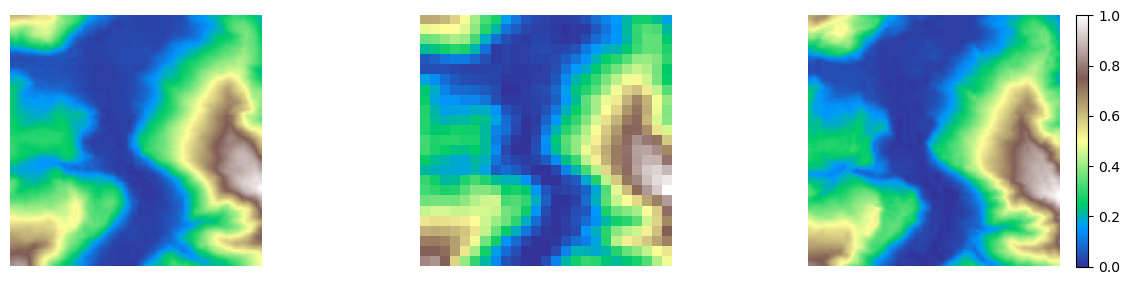

In [9]:
# """sampling"""
import os
import paddle
import paddle.nn as nn
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
from paddle import optimizer
import logging
import numpy as np
import math

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class Diffusion:
    def __init__(self, noise_steps=50, img_size=120, device="cuda"):
        self.noise_steps = noise_steps
        self.img_size = img_size
        self.device = device

        self.k_k=30.0

        self.N_N=self.prepare_noise_schedule()[:, None, None, None]

    def prepare_noise_schedule(self):
        N=paddle.zeros(self.noise_steps+1)
        for t in range(1,self.noise_steps+1):
            N[t]=(math.sin((t/self.noise_steps)*math.pi-math.pi/2)+1)/2
        N[self.noise_steps]=1
        N[0]=0.00001
        return N

    def noise_images(self, HR,LR, t):
        e0=LR-HR
        mu= HR+self.N_N[t]*e0
        Ɛ = paddle.randn(shape=HR.shape)
        return mu + self.k_k*paddle.sqrt(self.N_N[t]) * Ɛ/255,Ɛ
        

    def sample_timesteps(self, n):
        return paddle.randint(low=1, high=45+1, shape=(n,))  #t[0,30]
        
    def sample(self,HR,LR, model, model2,n):
        logging.info(f"Sampling {n} new images....")
        Ɛ0 = paddle.randn(shape=HR.shape)
        x=LR+self.k_k*Ɛ0/255
        start=self.noise_steps
        
        model.eval()
        b1=25 # the breakpoint 
        with paddle.no_grad():
            for i in tqdm(reversed(range(b1, start+1)), position=0): 
                t = paddle.to_tensor([i] * x.shape[0]).astype("int64")
                predect_e0 = model(x,LR,t)
                
                alpha_t=self.N_N[i]-self.N_N[i-1]
                Ɛ_1 = paddle.randn(shape=HR.shape)
                x0=LR-predect_e0
                x=(self.N_N[t-1]/self.N_N[t])*x+alpha_t/self.N_N[t]*x0
                x=x+self.k_k*paddle.sqrt(self.N_N[i-1]/self.N_N[i]*alpha_t)*Ɛ_1/255
            for i in tqdm(reversed(range(1, b1)), position=0):
                t = paddle.to_tensor([i] * x.shape[0]).astype("int64")
                predect_Ɛ = model2(x,LR,t)
                alpha_t=self.N_N[i]-self.N_N[i-1]
                Ɛ_1 = paddle.randn(shape=predect_Ɛ.shape)
                if i>1:
                    x0=(x-self.N_N[t]*LR-self.k_k*paddle.sqrt(self.N_N[t]) * predect_Ɛ/255)/(1-self.N_N[t])
                    x=(self.N_N[t-1]/self.N_N[t])*x+alpha_t/self.N_N[t]*x0
                    x=x+self.k_k*paddle.sqrt(self.N_N[i-1]/self.N_N[i]*alpha_t)*Ɛ_1/255
                else:
                    x=(x-self.N_N[t]*LR-self.k_k*paddle.sqrt(self.N_N[t]) * predect_Ɛ/255)/(1-self.N_N[t])
                
        model.train()
        return x

def train(args):
    device = args.device
    # Model initialization
    model = UNet()
    model.eval()
    model2 = UNet()
    model2.eval()
    # Load the model and optimizer parameters
    model.set_state_dict(P.load('model/respre_1000.pdparams'))
    model2.set_state_dict(P.load('model/noisepre_1000.pdparams'))

    mse = nn.MSELoss()
    content_criterion = nn.L1Loss()
    # Initialization of the diffusion model
    diffusion = Diffusion(img_size=args.image_size, device=device)

    sample_batch=1
    HR,LR,LR0=read_test_dataset(sample_batch)
    sampled_images = diffusion.sample(HR,LR,model, model2,n=sample_batch)
    sampled_images=(sampled_images+1)/2
    HR=(HR+1)/2
    LR=(LR+1)/2
    LR0=(LR0+1)/2
    
    plt.figure(figsize=(15, 15))
    for i in range(sample_batch):
        img = sampled_images[i].transpose([1, 2, 0])
        img = np.array(img).astype("float64")
        img=img.squeeze()
        plt.subplot(4,3,i*3+1)
        plt.imshow(img,cmap='terrain')
        plt.axis('off')  
        # plt.colorbar(extend='both')

        LR00 = LR0[i].transpose([1, 2, 0])
        LR00 = np.array(LR00).astype("float64")
        LR00=LR00.squeeze()
        plt.subplot(4,3,i*3+2)
        plt.imshow(LR00,cmap='terrain')
        plt.axis('off')  

        HR0 = HR[i].transpose([1, 2, 0])
        HR0 = np.array(HR0).astype("float64")
        HR0=HR0.squeeze()
        plt.subplot(4,3,i*3+3)
        plt.imshow(HR0,cmap='terrain')
        plt.axis('off')  
        plt.colorbar()
    plt.show()

   
def launch():
    import argparse

    # parameter setting
    class ARGS:
        def __init__(self):
            self.epochs = 1001
            self.batch_size = 8
            self.image_size = 120
            self.dataset_path = r"car-pair"
            self.device = "cuda"
            self.lr = 1e-5

    args = ARGS()
    train(args)


if __name__ == '__main__':
    launch()
    pass